# Multimodal Chatbot for YouTube Video QA

In [ ]:
#!pip install -U yt-dlp
#!pip install -U opencv-python
#!pip install -U pinecone
#!pip install -U youtube-transcript-api
#!pip install -U langchain
#!pip install -U langchain_core
#!pip install -U langchain_openai
#!pip install -U langchain-community
#!pip install -U langchain-pinecone
#!pip install -U langgraph
#!pip install -U python-dotenv
#!pip install -U  youtube-transcript-api
#!pip install -U pytube
#!pip install -U pandas
#!pip install -U langsmith

## Importing libraries

In [43]:
import os
import ast
import time
import uuid
import torch
import pandas as pd
import gradio as gr
from yt_dlp import YoutubeDL
from typing import Literal, Annotated, List, Sequence
from typing_extensions import TypedDict
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.document_loaders.youtube import TranscriptFormat
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents.base import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from pydantic import BaseModel, Field
from tqdm.auto import tqdm
from pprint import pprint
from dotenv import load_dotenv, find_dotenv

### Initialization

In [44]:
_ = load_dotenv(find_dotenv())

OPENAI_API_KEY  = os.getenv('OPENAI_API_KEY')
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

LANGCHAIN_TRACING_V2=True
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="Final_Project"

# not sure if it's working without moving the embedding model to the gpu (embedding_model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, streaming=True, openai_api_key=OPENAI_API_KEY)

## Loading YouTube Videos

### Processing the data and adding metadata

In [45]:
# TODO: Load from a CSV or JSON
# Dictionary of YouTube video URLs
yt_vids = [
    {
        "short_title": "5ECharacter_WASD20",
        "url": "https://youtu.be/ZcNgj0KPYuA?si=hYnXDcf0AUIsbyuR",
        "channel": "WASD20",
        "topic": "StepByStep",
    },
    {
        "short_title": "2024Character_LazyDM",
        "url": "https://www.youtube.com/watch?v=BHPuUsuZtaY",
        "channel": "LazyDM",
        "topic": "StepByStep",
    },
    {
        "short_title": "2024Character_GinnyDi",
        "url": "https://youtu.be/TkJjy7WwrVM?si=3sAQlJyeoCYsmaPI",
        "channel": "GinnyDi",
        "topic": "StepByStep",
    },
    {
        "short_title": "CharPersonality_GinnyDi",
        "url": "https://youtu.be/pHPa7HwLkws?si=LZ1KZOditMxk4PKU",
        "channel": "GinnyDi",
        "topic": "Personality",
    },
    {
        "short_title": "WhatMakesAGoodCharacter_PointyHat",
        "url": "https://youtu.be/LLVJrK22gVA?si=V6_0nEFP3vo2JwAA",
        "channel": "PointyHat",
        "topic": "Personality",
    },
    {
        "short_title": "CharactersWithDrawback_PointyHat",
        "url": "https://youtu.be/HMR5zL5oTLw?si=qfyPyrKbVZ89-7fz",
        "channel": "PointyHat",
        "topic": "Personality",
    },
    {
        "short_title": "MakingCharacters_M.Colville",
        "url": "https://youtu.be/0K9mKpAMREU?si=FsVN66HLFW-zwKoj",
        "channel": "M.Colville",
        "topic": "General",
    },
]

In [46]:
# Function to fetch metadata with yt-dlp
def get_video_metadata(url):
    ydl_opts = {"quiet": True, "skip_download": True, "format": "best"}
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
        video_id = info.get("id")
        title = info.get("title")
        description = info.get("description")
    return video_id, title, description

### Creating a DataFrame with relevant Metadata

In [47]:
device = torch.device('cpu') # Fails on GPU

# List to store rows for the DataFrame
rows = []

# Process each video and build the DataFrame row by row
for video in tqdm(yt_vids, desc="Processing videos"):
    url = video["url"]
    video_id, title, description = get_video_metadata(url)
    
    loader = YoutubeLoader.from_youtube_url(
        url,
        add_video_info=False,  # Avoids using PyTube for title to prevent crashes
        transcript_format=TranscriptFormat.TEXT,
    )
    
    # Load the transcript documents (chunks)
    transcript = loader.load()
    
    # Split documents into manageable chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    splits = text_splitter.split_documents(transcript)
    
    # Append the data as a new row
    rows.append({
        "video_id": video_id,
        "short_title": video["short_title"],
        "title": title,
        "description": description,
        "channel": video["channel"],
        "topic": video["topic"],
        "chunks": splits  # Store chunked docs directly in this column
    })

# Create the DataFrame directly from the list of rows
video_df = pd.DataFrame(rows)
book_df = pd.read_csv('./data/combined_docs_final.csv')
book_df.dropna(subset=['page_content'], inplace=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Assign it back to cuda

Processing videos:   0%|          | 0/7 [00:00<?, ?it/s]

In [48]:
# Display the DataFrame
book_df.sample(10)

,page_number,chapter,page_content,tables_html
163,164,CHAPTER 3 | CHARACTER CLASSES,WIZARD FEATURES:\n\n \nProficiency:\n\n \nnan:...,{}
115,116,CHAPTER 3 | CHARACTER CLASSES,nan:\n\n \nnan:\n\n \nnan:\n\n \nnan:\n\n \nna...,{}
13,14,CHAPTER 1 | PLAYING THE GAME,"SOCIAL INTERACTION EXAMPLE:\nIn this scene, pl...",{}
99,100,CHAPTER 3 | CHARACTER CLASSES,MONK FEATURES:\n\n \nProficiency:\n\n \nLevel ...,{}
322,323,CHAPTER 7 | SPELLS,Draconic Spirit:\n\n \n(Coo:\n\n \nDRACONIC SP...,{}
171,172,CHAPTER 3 | CHARACTER CLASSES,nan:\n\n \nnan:\n\n \nnan:\n\n \nnan:\n\n \nFY...,{}
314,315,CHAPTER 7 | SPELLS,nan:\n\n \nSitent IMAGE CAN:\n\n \nCONCOCT ILL...,{}
313,314,CHAPTER 7 | SPELLS,"SHATTER:\n\n \nLevel 2 Evocation (Bard, Sorcer...",{}
128,129,CHAPTER 3 | CHARACTER CLASSES,Withdraw (Cost: Id6). Immediately after the at...,{}
24,25,CHAPTER 1 | PLAYING THE GAME,nan:\n\n \nnan:\n\n \nASTRIOE AGIAN’:\n\n \nSE...,{}


## Creating Pinecone Index

In [49]:
# configure client
pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "dnd-qa-index"

In [ ]:
# Delete the index if creating it from scratch is needed.
#pc.delete_index(index_name)

In [53]:
# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536, # OpenAI's ADA embedding model'
        metric='cosine',
        spec=ServerlessSpec(cloud='aws', region='us-east-1')
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

### Initializing Vectorstore and Embedding model

In [54]:
# Load and check the index
index = pc.Index(index_name)

# Set up the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002", show_progress_bar=False)
# Initialize the vector store with the embedding model and index
vectorstore = PineconeVectorStore(index=index, embedding=embedding_model)

### Embedding and Upserting to Pinecone

In [55]:
# Function to convert string representations of dictionaries to actual dictionaries
def str_to_dict(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return {}

# Apply the conversion to the 'tables_html' column
book_df['tables_html'] = book_df['tables_html'].apply(str_to_dict)
book_df['chapter'] = book_df['chapter'].fillna('Unknown Chapter')

In [56]:
# Process each row (page) for Pinecone vector storage
for _, row in tqdm(book_df.iterrows(), total=len(book_df), desc="Embedding and Upserting to Pinecone"):
    docs = []
    vector_ids = []

    # Split page content
    chunks = text_splitter.split_text(row["page_content"])
    
    for i, chunk in enumerate(chunks):
        doc = Document(
            page_content=chunk,
            metadata={
                'source': 'book',
                'page_number': row['page_number'],
                'chapter': row['chapter'],
                'chunk_index': i,
                'content_type': 'text'
            }
        )
        docs.append(doc)
        vector_ids.append(f"page{row['page_number']}_chunk{i}")  # Unique ID for each text chunk

    # Embed each HTML table directly and save the HTML as metadata
    for i, (table_key, table_html) in enumerate(row.get('tables_html', {}).items()):
        doc = Document(
            page_content=table_html,  # Embedding the HTML directly
            metadata={
                'source': 'book',
                'page_number': row['page_number'],
                'chapter': row['chapter'],
                'table_title': table_key,
                'content_type': 'table',
                'html': table_html  # Store original HTML for retrieval
            }
        )
        docs.append(doc)
        vector_ids.append(f"page{row['page_number']}_table{i}")  # Unique ID for each table

    # Add all documents to the vector store in one batch
    vectorstore.add_documents(docs, ids=vector_ids)

Embedding and Upserting to Pinecone:   0%|          | 0/340 [00:00<?, ?it/s]

In [57]:
# Process each video for Pinecone vector storage
for _, row in tqdm(video_df.iterrows(), total=len(video_df), desc="Embedding and Upserting to Pinecone"):

    docs = []
    vector_ids = []

    for i, chunk in enumerate(row["chunks"]):
        
        # Update each chunk's metadata to include both video-level and chunk-level details        
        chunk.metadata.update({
            "source": "video",
            "video_id": row["video_id"],
            "short_title": row["short_title"],
            "title": row["title"],
            "description": row["description"],
            "channel": row["channel"],
            "topic": row["topic"],
            #"step": row.get("specific_step", ""),  # e.g., "ability_scores"
        })
        
        # Append the Document and vector ID
        docs.append(chunk)
        vector_ids.append(f"{row['video_id']}_{i}") # Unique ID for each chunk
    
    # Upsert documents into Pinecone vector store with unique vector IDs and namespace
    #vectorstore.add_documents(docs, ids=vector_ids, namespace="character_creation")
    vectorstore.add_documents(docs, ids=vector_ids)

print("Documents successfully upserted to Pinecone.")

Embedding and Upserting to Pinecone:   0%|          | 0/7 [00:00<?, ?it/s]

Documents successfully upserted to Pinecone.


In [59]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1067}},
 'total_vector_count': 1067}

## Retrievers

LangChain’s PineconeVectorStore supports multiple search_type options, each optimized for different retrieval needs. Here are the main search_type options:

Similarity Search (search_type="similarity"):

This is the default search type and retrieves documents based on their cosine similarity or dot product with the query embedding.
It ranks documents purely based on their similarity score, making it suitable when only the closest matches are needed, without concerns for diversity.
Use case: Ideal when the goal is to retrieve the most relevant documents without prioritizing variety.

Maximal Marginal Relevance (MMR) Search (search_type="mmr"):

Balances similarity and diversity in the results, optimizing for cases where the user may benefit from a range of perspectives or different aspects of a topic.
It fetches a set number of documents (fetch_k) based on similarity, then uses lambda_mult to balance similarity and diversity.
Use case: Particularly useful in retrieval-augmented generation (RAG) scenarios where repeated content should be avoided, such as in summarization or answering open-ended questions.

Similarity Score Threshold (search_type="similarity_score_threshold"):

Filters documents based on a minimum similarity threshold (score_threshold), so only documents with a similarity score above this threshold are returned.
Allows for more targeted retrieval, ensuring results meet a certain relevance standard before being considered.
Use case: Useful in cases where only highly relevant documents are desired, and less relevant matches should be excluded.

In [60]:
# Define the filter for metadata
filter_criteria = {
    #"source": "book",
    #"topic": "StepByStep",
    #"channel": "WASD20",
}

In [61]:
# Basic similarity search
retriever_similarity = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5, # Number of documents to retrieve (default: 4)
        "filter":filter_criteria,
        })

# MMR search with diversity
retriever_mmr = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5, # k is the number of final documents to retrieve from MMR
        "fetch_k": 10, # Determines the number of documents to initially fetch from the vector store before applying MMR
        "lambda_mult": 0.5, # Controls the balance between relevance and diversity in MMR
        "filter":filter_criteria,
    })

# Similarity score threshold search
retriever_threshold = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 5,
        "score_threshold": 0.8, # Only retrieves if score >= 0.8
        "filter":filter_criteria,
        })

In [62]:
retriever_tool = create_retriever_tool(
    retriever_similarity,
    name="DnD_Retriever",
    description="Retrieve information about Dungeons and Dragons character creation from video transcripts.",
)
tools = [retriever_tool]

## LangGraph (Adaptive Rag)

In [63]:
class AgentState(TypedDict):
    """
    Represents the state of the grapgh and the agent.
    Storing conversation messages in a list that grows throughout the session.

    Attributes:
        messages: Sequence of messages exchanged in the conversation.
        question: The user's current question.
        generation: The generated response from the language model.
        documents: List of documents retrieved relevant to the question.
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: str
    generation: str
    documents: List[str]

### Data Models

In [64]:
# Route Query
class RouteQuery(BaseModel):
    """Route a user query to a retriever or to a generative llm."""

    route: Literal["retriever", "generative_llm"] = Field(
        ...,
        description="\
            Determine whether to route the user question to the vectorstore\
            through a retriever or to the generative language model's\
            if it's not related to DnD's character creation.",
    )
    
    
# Grade Documents
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="\
            Documents are relevant to the question, 'yes' or 'no'",
    )


# Grade Hallucinations
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

### Prompts and Chains

In [65]:
# Prompt for routing the query
system = """
You are an expert at routing a user question to a retriever or to a generative llm.\n
The retriever accesses a vectorstore with documents related to DnD (Dungeon & Dragons) character creation.\n
Use the retriever for questions on these topics. Otherwise, use the llm generation."""
route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])
# Chain (TODO: "llm" could be tweaked if needed)
question_router = route_prompt | llm.with_structured_output(RouteQuery)


# Prompt for grading documents
system = """
You are a grader assessing relevance of a retrieved document to a user question.\n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.\n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
doc_grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
])
# Chain (TODO: "llm" could be tweaked if needed)
retrieval_grader = doc_grade_prompt | llm.with_structured_output(GradeDocuments)


# Prompt for hallucination check
system = """
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.\n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
])
# Chain (TODO: "llm" could be tweaked if needed)
hallucination_grader = hallucination_prompt | llm.with_structured_output(GradeHallucinations)


# Prompt for question rewriter
system = """
You are a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n\n Formulate an improved question."),
])
# Chain (TODO: "llm" could be tweaked if needed)
question_rewriter = rewrite_prompt | llm | StrOutputParser()


# Prompt for generating answer
system = """
You are an assistant for question-answering tasks. \n
You are specialized in Dungeons & Dragons character creation. \n
Use the following pieces of retrieved context to answer the question. \n
If you don't know the answer, just say that you don't know. \n
Use three sentences maximum and keep the answer concise and educational."""
generate_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{conversation_history}"),
    ("human", "Question: \n\n {question} \n\n Context: {context}")
])
# Chain (TODO: "llm" could be tweaked if needed)
rag_chain = generate_prompt | llm | StrOutputParser()


### Functions

In [66]:
### Node Functions

# Retrieve relevant documents
def retrieve_docs(state):
    print("---RETRIEVE FROM VECTORSTORE---")
    documents = retriever_similarity.invoke(state["question"])
    state["documents"] = documents
    return {"documents": documents}


# Grade documents for relevance
def grade_documents(state):
    """ Determines whether the retrieved documents are relevant to the question. """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            continue
    print(f"--- ---RELEVANT DOCUMENTS: {len(filtered_docs)}/{len(documents)}---")
    return {"documents": filtered_docs, "question": question}


def format_conversation_history(messages):
    """Format the conversation history into a string."""
    conversation_history = ""
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation_history += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            conversation_history += f"Assistant: {message.content}\n"
        else:
            conversation_history += f"{message.__class__.__name__}: {message.content}\n"
    return conversation_history.strip()

def generate_answer(state):
    """Generate a response based on the documents or internal knowledge."""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    messages = state["messages"].copy()  # Copy the conversation history

    # Build the conversation history as a formatted string
    conversation_history = format_conversation_history(messages)

    # Extract text content from each Document
    context = "\n".join([doc.page_content for doc in documents])

    # Prepare inputs for the chain
    inputs = {
        "conversation_history": conversation_history,
        "context": context,
        "question": question
    }

    # Generate the answer using rag_chain
    generation = rag_chain.invoke(inputs)

    # Append the current question and the AI's response to the conversation history
    messages.append(HumanMessage(content=question))
    messages.append(AIMessage(content=generation))

    # Return the updated messages and generation
    return {"messages": messages, "generation": generation}


def generate_answer_direct(state):
    """Generate a response based on internal knowledge."""
    print("---GENERATE DIRECTLY---")
    question = state["question"]
    messages = state["messages"].copy()  # Copy the conversation history

    # Append the current question to the conversation history
    messages.append(HumanMessage(content=question))

    # Generate the answer using the conversation history
    generation = llm.invoke(messages)

    # Append the AI's response to the conversation history
    messages.append(AIMessage(content=generation.content))

    # Return the updated messages and generation
    return {"messages": messages, "generation": generation.content}


# Transform the query if initial retrieval is not useful
def rewrite_query(state):
    """ Transform the query to produce a better question. """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [67]:
### Conditional Edge Functions

# Route the question based on its content
def decide_retrieve_generate(state):
    """ Determines whether to retrieve relevant documents or generate an answer directly."""
    print("---ROUTE QUESTION---")
    question = state["question"]
    
    next_action = question_router.invoke({"question": question})
    if next_action.route == "retriever":
        print("\t---ROUTE QUESTION TO VECTORSTORE---")
        return "to_retrieve"
    else:
        print("\t---ROUTE QUESTION TO LLM---")
        return "to_generate"


def decide_generate_rewrite(state): # TODO: Change name
    """ Determines whether to generate an answer, or re-generate a question. """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if filtered_documents:
        print("\t---DECISION: GENERATE---")
        return "relevant"
    else:
        print("\t---DECISION: NO DOCUMENT IS RELEVANT, TRANSFORM QUERY---")
        return "not_relevant"
    
def decide_end_rewrite(state):
    """ Determines whether the generation is grounded in the document and answers question. """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("\t---DECISION: GENERATION IS GROUNDED IN DOCUMENTS, END---")
        return "grounded"
    else:
        print("\t---DECISION: GENERATION IS AN HALLUCINATION, REWRITE---")
        return "hallucination"

### Graph Construction

In [68]:
memory = MemorySaver()

# Create the workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieve", retrieve_docs)
workflow.add_node("generate", generate_answer)
workflow.add_node("generate_direct", generate_answer_direct)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite_query", rewrite_query)

# Define edges based on the workflow
# Start with routing the question to decide between retrieval or direct generation
workflow.add_conditional_edges(START, decide_retrieve_generate, {
    "to_retrieve": "retrieve",
    "to_generate": "generate_direct"
})
workflow.add_edge("generate_direct", END)

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_generate_rewrite, {
    "relevant": "generate",
    "not_relevant": "rewrite_query"
})
workflow.add_edge("rewrite_query", "retrieve")

workflow.add_conditional_edges("generate", decide_end_rewrite, {
    "grounded": END,
    "hallucination": "rewrite_query"
})

# Compile the workflow
app = workflow.compile(checkpointer=memory)

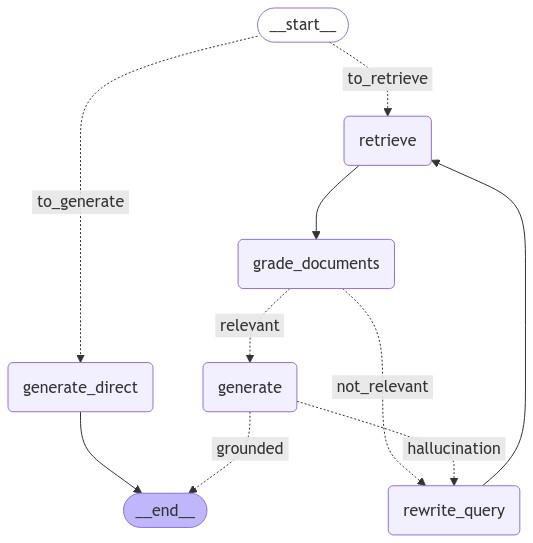

In [69]:
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Graph Execution

In [70]:
# TODO: Add Description
def initialize_state() -> AgentState:
    # Initialize a new state according to AgentState structure
    return AgentState(
        messages=[],
        question="",
        generation="",
        documents=[],
    )


# WIP
def stream_app(state: AgentState, user_query: str):

    # Update the state with the user's query
    state["question"] = user_query

    for output in app.stream(state):
        # Process the output from the agent
        for key, value in output.items():
            print(f"Node: '{key}':")
            #pprint(value, indent=4, width=100)
            print("*"+"-"*40+"*")
    
    pprint(state["messages"][-1])
    
    
def call_app(state: AgentState, user_query: str, thread_id: str):
    """Handles user input and invokes the app to generate a response."""
    # Update the state with the user's query
    state["question"] = user_query

    # Invoke the app with the updated state
    result = app.invoke(state, config={"configurable": {"thread_id": thread_id}})
    
    # Update the state with the result to maintain the conversation history
    state["messages"] = result["messages"]

    # Optionally, return the assistant's response
    return result["generation"]


def display_conversation_history(state: AgentState):
    """Display the conversation history stored in the agent's state."""
    for message in state['messages']:
        if isinstance(message, HumanMessage):
            print(f"User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"Assistant: {message.content}")
        else:
            # Handle any other message types if necessary
            print(f"{message.__class__.__name__}: {message.content}")

In [71]:
# Initialize the agent state
state = initialize_state()
# Generate a new unique thread_id
thread_id = str(uuid.uuid4())

In [83]:
response = call_app(state, "How can I ensure my DnD character is deep and rich in personality and has an interesting character arch?", thread_id)

---ROUTE QUESTION---
	---ROUTE QUESTION TO LLM---
---GENERATE DIRECTLY---


In [82]:
pprint(response)

('In Dungeons & Dragons, there are twelve main classes available for character '
 'creation, each with unique abilities and playstyles. The classes are '
 'Barbarian, Bard, Cleric, Druid, Fighter, Monk, Paladin, Ranger, Rogue, '
 'Sorcerer, Warlock, and Wizard. Each class also has multiple subclasses that '
 "further define a character's abilities and role in the game.")


In [73]:
""" response = call_app(state, "Hello, my name is Javi", thread_id)
response = call_app(state, "What's my name?", thread_id)
response = call_app(state, "How do ability modifiers work in Dnd?", thread_id) """

' response = call_app(state, "Hello, my name is Javi", thread_id)\nresponse = call_app(state, "What\'s my name?", thread_id)\nresponse = call_app(state, "How do ability modifiers work in Dnd?", thread_id) '

In [74]:
display_conversation_history(state)

User: How do ability modifiers work in Dnd?
Assistant: In Dungeons & Dragons (D&D), ability modifiers are numerical values that represent a character's proficiency in various abilities. These modifiers are derived from a character's ability scores, which range from 1 to 20 (or higher in some cases). The six core abilities in D&D are:

1. **Strength**: Measures physical power and carrying capacity.
2. **Dexterity**: Measures agility, reflexes, and balance.
3. **Constitution**: Measures health, stamina, and resilience.
4. **Intelligence**: Measures reasoning, memory, and learning ability.
5. **Wisdom**: Measures perception, insight, and intuition.
6. **Charisma**: Measures force of personality, persuasiveness, and leadership.

### Calculating Ability Modifiers

The ability modifier for each ability score is calculated using the following formula:

\[
\text{Modifier} = \left(\text{Ability Score} - 10\right) \div 2
\]

You round down to the nearest whole number. Here are some examples:

- 

## Gradio

In [75]:
#!pip install -U gradio

### Simple Gradio

In [76]:
from langchain.schema import AIMessage as schema_AIMessage
from langchain.schema import HumanMessage as schema_HumanMessage

def predict(message, history, thread_id):
    # Format history to LangChain-compatible format
    history_langchain_format = []
    for msg in history:
        if msg['role'] == "user":
            history_langchain_format.append(schema_HumanMessage(content=msg['content']))
        elif msg['role'] == "assistant":
            history_langchain_format.append(schema_AIMessage(content=msg['content']))

    # Append the new user message
    history_langchain_format.append(schema_HumanMessage(content=message))
    
    # Prepare the state with the formatted history
    state = {
        "messages": history_langchain_format,
        "question": message,  # Include the current question for context
        "generation": "",      # Initialize generation as empty
        "documents": []        # Initialize documents as empty
    }
    
    # Call the graph with the formatted history and get the final result
    result = app.invoke(state, config={"configurable": {"thread_id": thread_id}})
    
    # Extract the final response content from the result
    final_response = result['messages'][-1].content
    
    # Return response to Gradio
    return final_response

# Launch Gradio interface
gr.ChatInterface(predict, type="messages").launch()

c:\Users\Javi\anaconda3\envs\FinalProyect\Lib\site-packages\gradio\utils.py:999: UserWarning: Expected 3 arguments for function <function predict at 0x000001E4EE64D3A0>, received 2.
  warnings.warn(
c:\Users\Javi\anaconda3\envs\FinalProyect\Lib\site-packages\gradio\utils.py:1003: UserWarning: Expected at least 3 arguments for function <function predict at 0x000001E4EE64D3A0>, received 2.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
